# Physics-Informed Neural Networks (PINNs) for 1D Heat Equation

This notebook demonstrates a corrected implementation of PINNs to solve the 1D heat equation:

$$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$$

with appropriate initial and boundary conditions.



In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import warnings
import time
from typing import Tuple, Optional

warnings.filterwarnings("ignore")

# Device setup
def setup_device() -> torch.device:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

device = setup_device()

# Reproducibility
def set_seeds(seed: int = 42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds()
print("Environment setup complete!")


Using GPU: NVIDIA GeForce RTX 4050 Laptop GPU
Environment setup complete!


## Neural Network Architecture

We define a multi-layer perceptron with proper initialization and activation functions.

In [36]:
import torch
import torch.nn as nn

class PINN(nn.Module):
    """Physics-Informed Neural Network for solving the 1D heat equation u_t = α * u_xx."""
    
    def __init__(self, layers: list, activation: nn.Module = nn.Tanh()):
        """
        Args:
            layers: List specifying number of neurons in each layer
                    (2 for input x,t and 1 for output u)
            activation: Nonlinear activation function (default: Tanh)
        """
        super().__init__()
        
        self.activation = activation
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)
        ])
        self.init_weights()
    
    def init_weights(self):
        """Xavier initialization"""
        for layer in self.layers:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass: input (x,t) → output u(x,t)."""
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)

# Architecture
layers = [2, 10, 10, 1]
model = PINN(layers).to(device)

print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
print(model)

Model created with 151 parameters
PINN(
  (activation): Tanh()
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)


## Problem Setup: 1D Heat Equation

We solve the heat equation on domain [0,1] × [0,1] with:
- Initial condition: u(x,0) = sin(πx)
- Boundary conditions: u(0,t) = u(1,t) = 0
- Thermal diffusivity: α = 0.01

In [37]:
# Problem parameters
alpha = 0.01  # Thermal diffusivity
L, T = 1.0, 1.0  # Domain length and final time

# Analytical solution for validation
def analytical_solution(x: np.ndarray, t: np.ndarray) -> np.ndarray:
    """u(x,t) = exp(-π²αt) * sin(πx)"""
    return np.exp(-np.pi**2 * alpha * t) * np.sin(np.pi * x)

# Generate training data
def generate_training_data(n_pde=10_000, n_bc=100, n_ic=100):
    """Generate training data for PDE, boundary, and initial conditions."""
    
    # PDE points (interior)
    x_pde = np.random.uniform(0, L, (n_pde, 1))
    t_pde = np.random.uniform(0, T, (n_pde, 1))
    print("Interior Points Table:")
    print("x\tt")
    for i in range(min(5, n_pde)):
        print(f"{x_pde[i,0]:.4f}\t{t_pde[i,0]:.4f}")
    print("...")
    
    # Boundary conditions: u(0,t)=u(1,t)=0
    x_bc = np.vstack([np.zeros((n_bc // 2, 1)), np.ones((n_bc // 2, 1))])
    t_bc = np.random.uniform(0, T, (n_bc, 1))
    u_bc = np.zeros((n_bc, 1))
    bc_table = np.hstack([x_bc, t_bc, u_bc])
    print("Boundary Condition Table:")
    print("x\tt\tu")
    for i in range(min(5, n_bc)):
        print(f"{bc_table[i,0]:.4f}\t{bc_table[i,1]:.4f}\t{bc_table[i,2]:.4f}")
    print("...")
    
    # Initial condition: u(x,0)=sin(πx)
    x_ic = np.random.uniform(0, L, (n_ic, 1))
    t_ic = np.zeros((n_ic, 1))
    u_ic = np.sin(np.pi * x_ic)
    ic_table = np.hstack([x_ic, t_ic, u_ic])
    print("Initial Condition Table:")
    print("x\tt\tu")
    for i in range(min(5, n_ic)):
        print(f"{ic_table[i,0]:.4f}\t{ic_table[i,1]:.4f}\t{ic_table[i,2]:.4f}")
    print("...")
    
    return (x_pde, t_pde), (x_bc, t_bc, u_bc), (x_ic, t_ic, u_ic)

# Generate
pde_data, bc_data, ic_data = generate_training_data()
print(f"Generated training data:")
print(f"  PDE points: {len(pde_data[0])}")
print(f"  BC points: {len(bc_data[0])}")
print(f"  IC points: {len(ic_data[0])}")

Interior Points Table:
x	t
0.3745	0.3736
0.9507	0.3329
0.7320	0.1762
0.5987	0.6073
0.1560	0.4766
...
Boundary Condition Table:
x	t	u
0.0000	0.7300	0.0000
0.0000	0.1845	0.0000
0.0000	0.3466	0.0000
0.0000	0.6633	0.0000
0.0000	0.4821	0.0000
...
Initial Condition Table:
x	t	u
0.9058	0.0000	0.2917
0.0535	0.0000	0.1671
0.3084	0.0000	0.8242
0.2881	0.0000	0.7866
0.6264	0.0000	0.9222
...
Generated training data:
  PDE points: 10000
  BC points: 100
  IC points: 100


## Physics Loss Functions

The key fix here is proper gradient handling to avoid the autograd error.

In [38]:
def pde_residual(model: nn.Module, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """
    Compute PDE residual: ∂u/∂t - α∂²u/∂x²
    """
    # Create new tensors with gradient tracking 
    x_pde = x.clone().detach().requires_grad_(True)
    t_pde = t.clone().detach().requires_grad_(True)
    
    # Combine inputs
    inputs = torch.cat([x_pde, t_pde], dim=1)
    
    # Forward pass
    u = model(inputs) 
    
    # print(f"Model Output: \n {u}")

    # Compute gradients
    u_t = torch.autograd.grad(
        outputs=u, inputs=t_pde,
        grad_outputs=torch.ones_like(u),
        create_graph=True, retain_graph=True
    )[0]

    # print(f"u_t: \n {u_t}")
    
    u_x = torch.autograd.grad(
        outputs=u, inputs=x_pde,
        grad_outputs=torch.ones_like(u),
        create_graph=True, retain_graph=True
    )[0]
    
    # print(f"u_x: \n {u_x}")

    u_xx = torch.autograd.grad(
        outputs=u_x, inputs=x_pde,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True, retain_graph=True
    )[0]

    # print(f"u_xx: \n {u_xx}")
    
    # PDE residual: ∂u/∂t - α∂²u/∂x²
    pde_loss = u_t - alpha * u_xx
    
    return pde_loss

def compute_losses(model: nn.Module, pde_data: tuple, bc_data: tuple, ic_data: tuple) -> dict:
    """Compute all loss components."""
    
    # Convert data to tensors on correct device
    x_pde = torch.FloatTensor(pde_data[0]).to(device)
    t_pde = torch.FloatTensor(pde_data[1]).to(device)
    
    x_bc = torch.FloatTensor(bc_data[0]).to(device)
    t_bc = torch.FloatTensor(bc_data[1]).to(device)
    u_bc = torch.FloatTensor(bc_data[2]).to(device)
    
    x_ic = torch.FloatTensor(ic_data[0]).to(device)
    t_ic = torch.FloatTensor(ic_data[1]).to(device)
    u_ic = torch.FloatTensor(ic_data[2]).to(device)
    
    # PDE loss
    pde_residual_values = pde_residual(model, x_pde, t_pde)
    loss_pde = torch.mean(pde_residual_values**2)
    
    # Boundary condition loss
    bc_inputs = torch.cat([x_bc, t_bc], dim=1)
    u_bc_pred = model(bc_inputs)
    loss_bc = torch.mean((u_bc_pred - u_bc)**2)
    
    # Initial condition loss
    ic_inputs = torch.cat([x_ic, t_ic], dim=1)
    u_ic_pred = model(ic_inputs)
    loss_ic = torch.mean((u_ic_pred - u_ic)**2)
    
    return {
        'pde': loss_pde,
        'bc': loss_bc,
        'ic': loss_ic,
        'total': loss_pde + loss_bc + loss_ic
    }

print("Physics loss functions defined successfully!")

Physics loss functions defined successfully!


## Training Loop

In [39]:
def train_pinn(model: nn.Module, pde_data: tuple, bc_data: tuple, ic_data: tuple,
               epochs: int = 10000, lr: float = 1e-3, print_every: int = 1000,
               early_stopping_patience: int = 2000, min_loss_improvement: float = 1e-6):
    """Train the PINN model"""
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.9)
    
    # Training history
    history = {
        'total_loss': [],
        'pde_loss': [],
        'bc_loss': [],
        'ic_loss': [],
        'learning_rate': []
    }
    
    # Early stopping variables
    best_loss = float('inf')
    patience_counter = 0
    
    print("Starting training...")
    start_time = time.time()
    
    for epoch in range(epochs):
        # Zero gradients
        optimizer.zero_grad()
        
        # Compute losses
        losses = compute_losses(model, pde_data, bc_data, ic_data)
        total_loss = losses['total']
        
        # Backward pass
        total_loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer step
        optimizer.step()
        scheduler.step()
        
        # Store history
        history['total_loss'].append(total_loss.item())
        history['pde_loss'].append(losses['pde'].item())
        history['bc_loss'].append(losses['bc'].item())
        history['ic_loss'].append(losses['ic'].item())
        history['learning_rate'].append(scheduler.get_last_lr()[0])
        
        # Early stopping check
        if total_loss.item() < best_loss - min_loss_improvement:
            best_loss = total_loss.item()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Print progress
        if (epoch + 1) % print_every == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch {epoch+1:6d} | "
                  f"Total: {total_loss.item():.2e} | "
                  f"PDE: {losses['pde'].item():.2e} | "
                  f"BC: {losses['bc'].item():.2e} | "
                  f"IC: {losses['ic'].item():.2e} | "
                  f"LR: {scheduler.get_last_lr()[0]:.2e} | "
                  f"Time: {elapsed_time:.1f}s")
        
        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f"\nEarly stopping at epoch {epoch+1} (patience: {early_stopping_patience})")
            break
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.1f}s")
    print(f"Final loss: {history['total_loss'][-1]:.2e}")
    
    return history

# Train the model
history = train_pinn(model, pde_data, bc_data, ic_data, epochs=2000, lr=1e-3)

Starting training...
Epoch   1000 | Total: 1.75e-03 | PDE: 1.35e-03 | BC: 1.05e-04 | IC: 2.86e-04 | LR: 1.00e-03 | Time: 8.2s
Epoch   2000 | Total: 4.64e-04 | PDE: 3.52e-04 | BC: 2.52e-05 | IC: 8.61e-05 | LR: 9.00e-04 | Time: 15.8s

Training completed in 15.8s
Final loss: 4.64e-04


## Results Visualization

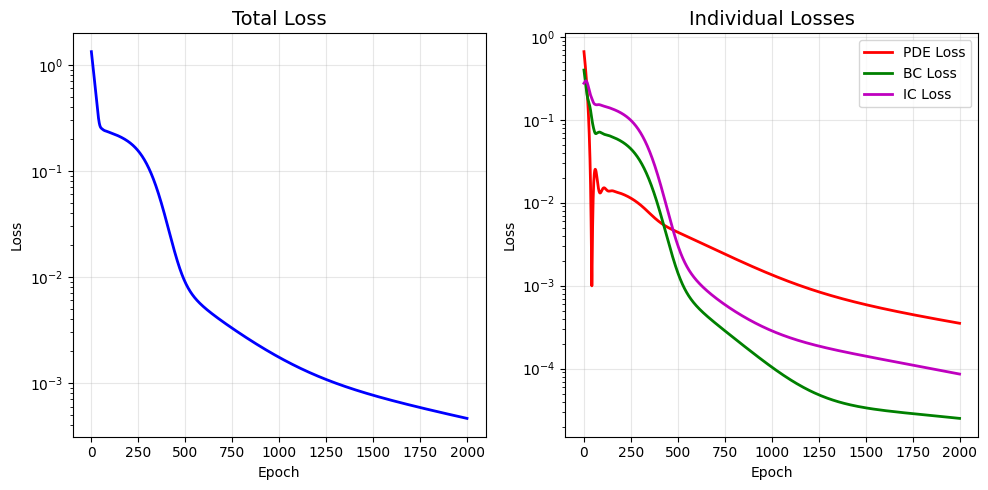

In [40]:
def plot_training_history(history: dict):
    """Plot training loss history."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Total loss
    axes[0].semilogy(history['total_loss'], 'b-', linewidth=2)
    axes[0].set_title('Total Loss', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True, alpha=0.3)
    
    # Individual losses
    axes[1].semilogy(history['pde_loss'], 'r-', label='PDE Loss', linewidth=2)
    axes[1].semilogy(history['bc_loss'], 'g-', label='BC Loss', linewidth=2)
    axes[1].semilogy(history['ic_loss'], 'm-', label='IC Loss', linewidth=2)
    axes[1].set_title('Individual Losses', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

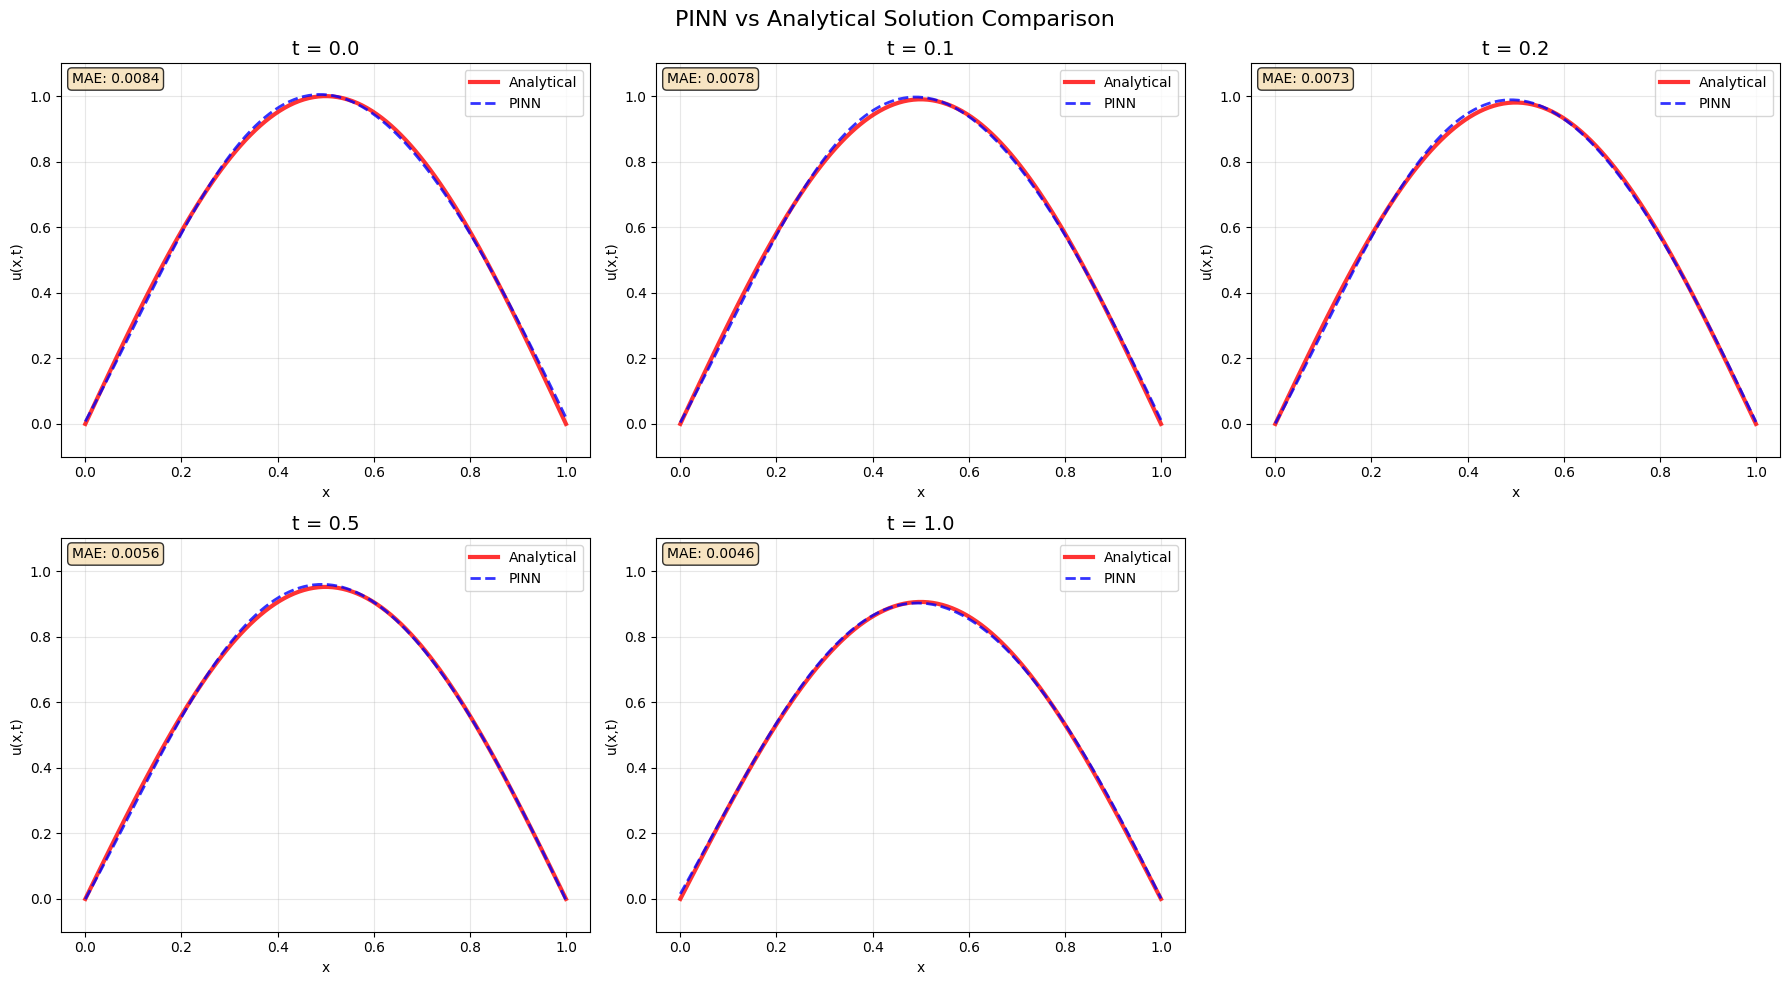

In [41]:
def evaluate_solution(model: nn.Module, n_points: int = 100):
    """Evaluate the learned solution and compare with analytical solution."""
    
    model.eval()
    
    # Create evaluation grid
    x_eval = np.linspace(0, L, n_points)
    t_eval = np.array([0.0, 0.1, 0.2, 0.5, 1.0])  # Different time snapshots
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Plot solutions at different times
    for i, t_val in enumerate(t_eval):
        if i >= 5:  # Only plot first 5 time snapshots
            break
        
        row = i // 3
        col = i % 3
        
        # Prepare input data
        X_eval, T_eval = np.meshgrid(x_eval, [t_val])
        x_flat = X_eval.flatten().reshape(-1, 1)
        t_flat = T_eval.flatten().reshape(-1, 1)
        
        # Convert to tensors
        x_tensor = torch.FloatTensor(x_flat).to(device)
        t_tensor = torch.FloatTensor(t_flat).to(device)
        inputs = torch.cat([x_tensor, t_tensor], dim=1)
        
        # PINN prediction
        with torch.no_grad():
            u_pred = model(inputs).cpu().numpy().flatten()
        
        # Analytical solution
        u_exact = analytical_solution(x_eval, t_val)
        
        # Plot comparison
        axes[row, col].plot(x_eval, u_exact, 'r-', linewidth=3, label='Analytical', alpha=0.8)
        axes[row, col].plot(x_eval, u_pred, 'b--', linewidth=2, label='PINN', alpha=0.8)
        axes[row, col].set_title(f't = {t_val:.1f}', fontsize=14)
        axes[row, col].set_xlabel('x')
        axes[row, col].set_ylabel('u(x,t)')
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].set_ylim(-0.1, 1.1)
        
        # Calculate error
        error = np.mean(np.abs(u_pred - u_exact))
        axes[row, col].text(0.02, 0.95, f'MAE: {error:.4f}', 
                           transform=axes[row, col].transAxes, 
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # Remove empty subplot
    if len(t_eval) < 6:
        axes[1, 2].remove()
    
    plt.suptitle('PINN vs Analytical Solution Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return None

# Evaluate the solution
evaluate_solution(model)


## Solution Heatmap Visualization

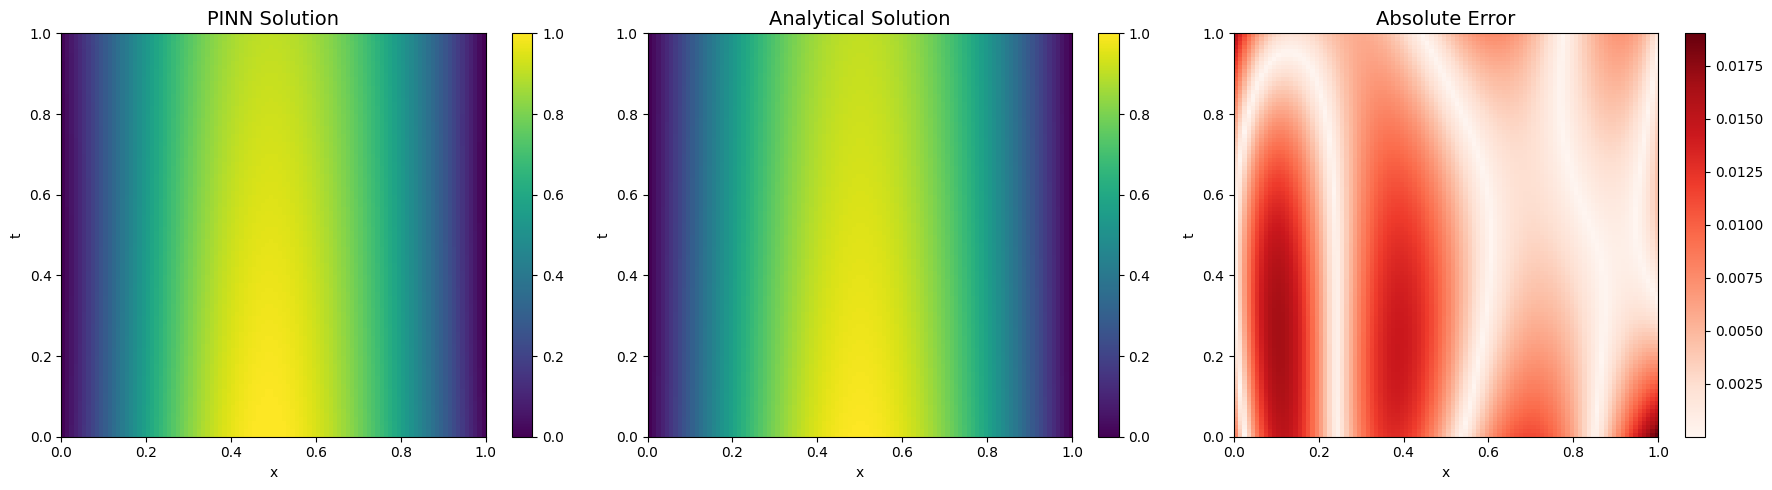

Solution Statistics:
  Maximum absolute error: 0.019033
  Mean absolute error: 0.005599
  Root mean square error: 0.007090
  Relative error (L2): 0.010578


In [42]:
def plot_solution_heatmap(model: nn.Module, nx: int = 100, nt: int = 100):
    """Create a heatmap visualization of the solution."""
    
    model.eval()
    
    # Create meshgrid
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    X, T_grid = np.meshgrid(x, t)
    
    # Flatten for neural network input
    x_flat = X.flatten().reshape(-1, 1)
    t_flat = T_grid.flatten().reshape(-1, 1)
    
    # Convert to tensors
    x_tensor = torch.FloatTensor(x_flat).to(device)
    t_tensor = torch.FloatTensor(t_flat).to(device)
    inputs = torch.cat([x_tensor, t_tensor], dim=1)
    
    # PINN prediction
    with torch.no_grad():
        u_pred = model(inputs).cpu().numpy().reshape(nt, nx)
    
    # Analytical solution
    u_exact = analytical_solution(X, T_grid)
    
    # Error
    error = np.abs(u_pred - u_exact)
    
    # Create plots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # PINN solution
    im1 = axes[0].imshow(u_pred, aspect='auto', origin='lower', 
                         extent=[0, L, 0, T], cmap='viridis', vmin=0, vmax=1)
    axes[0].set_title('PINN Solution', fontsize=14)
    axes[0].set_xlabel('x')
    axes[0].set_ylabel('t')
    plt.colorbar(im1, ax=axes[0])
    
    # Analytical solution
    im2 = axes[1].imshow(u_exact, aspect='auto', origin='lower', 
                         extent=[0, L, 0, T], cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title('Analytical Solution', fontsize=14)
    axes[1].set_xlabel('x')
    axes[1].set_ylabel('t')
    plt.colorbar(im2, ax=axes[1])
    
    # Error
    im3 = axes[2].imshow(error, aspect='auto', origin='lower', 
                         extent=[0, L, 0, T], cmap='Reds')
    axes[2].set_title('Absolute Error', fontsize=14)
    axes[2].set_xlabel('x')
    axes[2].set_ylabel('t')
    plt.colorbar(im3, ax=axes[2])
    
    plt.tight_layout()
    plt.show()
    
    # Print error statistics
    print(f"Solution Statistics:")
    print(f"  Maximum absolute error: {np.max(error):.6f}")
    print(f"  Mean absolute error: {np.mean(error):.6f}")
    print(f"  Root mean square error: {np.sqrt(np.mean(error**2)):.6f}")
    print(f"  Relative error (L2): {np.linalg.norm(error) / np.linalg.norm(u_exact):.6f}")

# Create heatmap visualization
plot_solution_heatmap(model)

## Model Testing

In [43]:
def validate_pde_satisfaction(model: nn.Module, n_test: int = 1000):
    """Test how well the trained model satisfies the PDE."""
    
    model.eval()
    
    # Generate random test points
    x_test = np.random.uniform(0, L, (n_test, 1))
    t_test = np.random.uniform(0, T, (n_test, 1))
    
    # Convert to tensors WITH requires_grad=True for derivative computation
    x_tensor = torch.FloatTensor(x_test).to(device).requires_grad_(True)
    t_tensor = torch.FloatTensor(t_test).to(device).requires_grad_(True)
    
    # Compute PDE residual (gradients ARE needed here)
    residual = pde_residual(model, x_tensor, t_tensor)
    residual_values = residual.detach().cpu().numpy().flatten()
    
    # Statistics
    print(f"PDE Residual Statistics (n={n_test} random points):")
    print(f"  Mean absolute residual: {np.mean(np.abs(residual_values)):.6f}")
    print(f"  Max absolute residual: {np.max(np.abs(residual_values)):.6f}")
    print(f"  RMS residual: {np.sqrt(np.mean(residual_values**2)):.6f}")
    print(f"  Standard deviation: {np.std(residual_values):.6f}")

# Validate PDE satisfaction
validate_pde_satisfaction(model)

PDE Residual Statistics (n=1000 random points):
  Mean absolute residual: 0.014622
  Max absolute residual: 0.070004
  RMS residual: 0.018755
  Standard deviation: 0.018755


## Model Summary

In [44]:
# Print final summary
print("PINN Training Summary: ")
print(f"Problem: 1D Heat Equation")
print(f"Domain: [0, {L}] × [0, {T}]")
print(f"Thermal diffusivity (α): {alpha}")
print(f"Network architecture: {layers}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Final training loss: {history['total_loss'][-1]:.2e}")
print(f"Training epochs: {len(history['total_loss'])}")
print(f"Device used: {device}")

PINN Training Summary: 
Problem: 1D Heat Equation
Domain: [0, 1.0] × [0, 1.0]
Thermal diffusivity (α): 0.01
Network architecture: [2, 10, 10, 1]
Total parameters: 151
Final training loss: 4.64e-04
Training epochs: 2000
Device used: cuda
